# **1. Data preprocessing**

In [9]:
from ANN_utility.Data_preprocess import Data_preprocess
import torch
import pandas as pd
import numpy as np

#setting device
device = torch.device("mps")

#Preprocessing data
preprocess = Data_preprocess(path = "./Database/Secfp_ro5.csv", y_name = "pChEMBL",
                             threshold = 7, col_drop = "Canomicalsmiles",
                             device = device, batch_size = 32)
preprocess.fit()

#Getting train_loader
train_loader = preprocess.train_loader
valid_loader = preprocess.valid_loader
test_loader = preprocess.test_loader

# **2. Training baseline model**

Epoch: 5/20..  Training Loss: 0.506..  validation Loss: 0.487..  validation f1_score: 0.594..  validation average precision: 0.849.. 
Epoch: 10/20..  Training Loss: 0.396..  validation Loss: 0.357..  validation f1_score: 0.800..  validation average precision: 0.865.. 
Epoch: 15/20..  Training Loss: 0.343..  validation Loss: 0.305..  validation f1_score: 0.800..  validation average precision: 0.884.. 
Epoch: 20/20..  Training Loss: 0.310..  validation Loss: 0.270..  validation f1_score: 0.775..  validation average precision: 0.898.. 


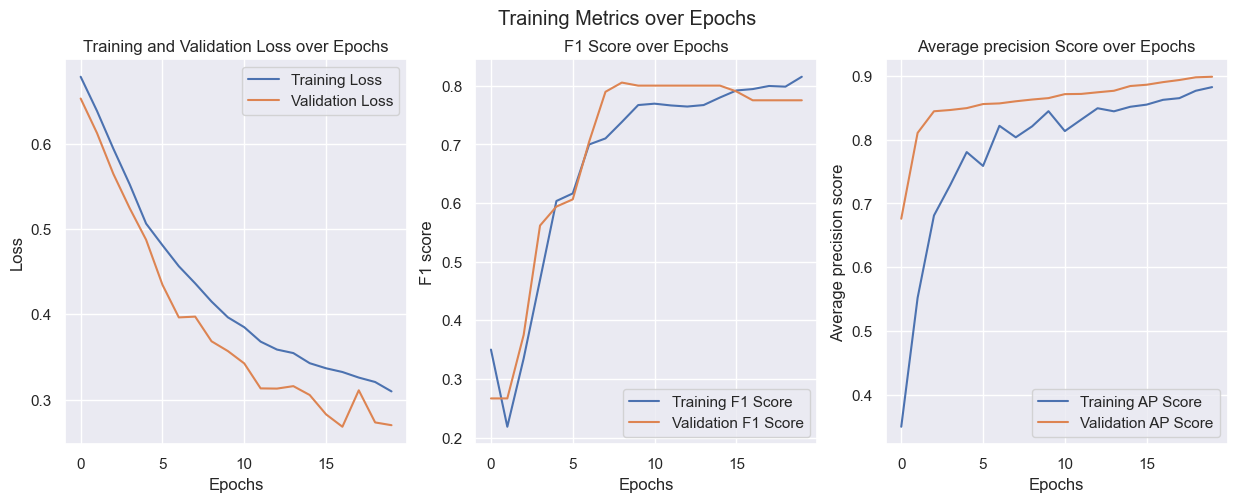

Saving...
Complete the process...


In [3]:
from ANN_utility.ANN import Net
from ANN_utility.model_pipeline import model_pipeline

#Define model architecture
params ={"in_features" : 2048,
         "n_layers_mlp" : 2,
         "dense_neurons": 20,
         "rate": 0.5}

net = Net(params)

#Training model
optimizer = torch.optim.Adam(net.parameters(), lr= 0.0001, weight_decay = 0.01)
criterion = torch.nn.BCELoss()
save_dir = "./ANN_utility/ANN_model_baseline.pth"

pip = model_pipeline(model = net, params = params, criterion = criterion, optimizer = optimizer, 
                    epochs =20, train_loader = train_loader, valid_loader = valid_loader,
                    seed = 42, device = device, save_dir  = save_dir,show_progress = True)
pip.fit()

# **3. Validation baseline**

## **3.1. Cross validation**

In [4]:
from sklearn.model_selection import RepeatedStratifiedKFold

X = preprocess.data_bin.drop(preprocess.data_bin.columns[0],axis = 1)
y = preprocess.data_bin["pChEMBL"]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=42)

pip.cross_val_score(X=X, y=y, model = net,cv=cv, batch_size = 32, device = device)

Fold: 1..  validation f1_score: 0.716..  validation average precision: 0.765.. 
Fold: 2..  validation f1_score: 0.857..  validation average precision: 0.961.. 
Fold: 3..  validation f1_score: 0.725..  validation average precision: 0.815.. 
Fold: 4..  validation f1_score: 0.773..  validation average precision: 0.892.. 
Fold: 5..  validation f1_score: 0.831..  validation average precision: 0.909.. 
Fold: 6..  validation f1_score: 0.757..  validation average precision: 0.875.. 
Fold: 7..  validation f1_score: 0.800..  validation average precision: 0.896.. 
Fold: 8..  validation f1_score: 0.769..  validation average precision: 0.884.. 
Fold: 9..  validation f1_score: 0.795..  validation average precision: 0.896.. 
Fold: 10..  validation f1_score: 0.825..  validation average precision: 0.860.. 
Fold: 11..  validation f1_score: 0.816..  validation average precision: 0.894.. 
Fold: 12..  validation f1_score: 0.776..  validation average precision: 0.911.. 
Fold: 13..  validation f1_score: 0.78

In [15]:
df_record_baseline.describe()

,F1_record,AP_record
count,30.000000,30.000000
mean,0.786814,0.872493
std,0.041567,0.046266
min,0.716049,0.764445
25%,0.759875,0.860447
50%,0.784297,0.883203
75%,0.823569,0.901127
max,0.857143,0.961471


In [12]:
#Saving baseline record
df_record_baseline = pd.DataFrame(pip.History)
df_record_baseline.to_csv("./Database/ANN_cv_baseline.csv", index = False)

## **3.2. External validation**

In [13]:
from ANN_utility.External_validation import external_validation
from sklearn.metrics import f1_score, average_precision_score, classification_report
path = "./ANN_utility/ANN_model_baseline.pth" #Directory contains trained model

external_val = external_validation(model = net,params = params,path = path,
                                   data_test = test_loader, device = device)


y_pre , y_true = external_val.predict()
y_proba, y_true = external_val.predict_proba()

#Classification report
print(classification_report(y_true, y_pre))

              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       237
         1.0       0.80      0.83      0.82        96

    accuracy                           0.89       333
   macro avg       0.87      0.87      0.87       333
weighted avg       0.89      0.89      0.89       333



In [17]:
print(f1_score(y_true, y_pre))
print(average_precision_score(y_true, y_proba))

0.816326530612245
0.9091107367066417
